#Projeto: Predição de aprovação de crédito usando Regressão Logística

Este projeto tem como objetivo utilizar um classificador de regressão logística para automatizar o processo de pré-aprovação de crédito. Os dados utilizados foram obtidos no site Kaggle e estão disponíveis no link: https://www.kaggle.com/datasets/krishnaraj30finance-loan-approval-prediction-data

# Pré-processamento

## Importando o dataset usando a API do Kaggle

In [51]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("krishnaraj30/finance-loan-approval-prediction-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/finance-loan-approval-prediction-data


In [52]:
import pandas as pd
import numpy as np
df = pd.read_csv('/root/.cache/kagglehub/datasets/krishnaraj30/finance-loan-approval-prediction-data/versions/1/train.csv')
print(df.shape) #Qual a forma do nosso dataframe?
df.head(3)

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


## Dados categóricos, numéricos e faltantes

Observamos que nosso dataframe contém 614 registros, cada um com 13 features. O primeiro passo no pré-processamento será identificar quais features são categóricas e quais são numéricas. Algumas, como **Married** e **Gender**, são facilmente classificáveis, enquanto outras, como **Credit History** e **Dependents**, não possuem uma classificação tão óbvia.

Para isso, analisaremos a natureza dos dados em cada coluna, o que também nos auxiliará na etapa seguinte: decidir como tratar os dados faltantes.


In [53]:
frequencias_por_coluna = {col: df[col].value_counts(dropna=False) for col in df.columns[1:]} #Aqui começamos da coluna índice 1 pois a de índice 0 é a dos ID's, que são únicos
for coluna, frequencias in frequencias_por_coluna.items():
    print(f"\nColuna: {coluna}")
    print(frequencias)
df.dtypes #Para vermos o tipo de dado de cada coluna


Coluna: Gender
Gender
Male      489
Female    112
NaN        13
Name: count, dtype: int64

Coluna: Married
Married
Yes    398
No     213
NaN      3
Name: count, dtype: int64

Coluna: Dependents
Dependents
0      345
1      102
2      101
3+      51
NaN     15
Name: count, dtype: int64

Coluna: Education
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64

Coluna: Self_Employed
Self_Employed
No     500
Yes     82
NaN     32
Name: count, dtype: int64

Coluna: ApplicantIncome
ApplicantIncome
2500     9
4583     6
6000     6
2600     6
5000     5
        ..
11000    1
3416     1
1907     1
3125     1
3727     1
Name: count, Length: 505, dtype: int64

Coluna: CoapplicantIncome
CoapplicantIncome
0.0       273
1666.0      5
2083.0      5
2500.0      5
1625.0      3
         ... 
2816.0      1
1083.0      1
3021.0      1
983.0       1
5063.0      1
Name: count, Length: 287, dtype: int64

Coluna: LoanAmount
LoanAmount
NaN      22
120.0    20
110.0    17
100.0    15
187.

,0
Loan_ID,object
Gender,object
Married,object
Dependents,object
Education,object
Self_Employed,object
ApplicantIncome,int64
CoapplicantIncome,float64
LoanAmount,float64
Loan_Amount_Term,float64


A partir desse resultado, podemos observar que faz sentido considerar as features "Credit History" e "Dependents" como categóricas, visto que a natureza numérica dos valores não parece desempenhar função.


In [54]:
categoricas = {'Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status'}
numericas = {'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'}


Podemos assim passar para a próxima etapa: lidar com os dados faltantes. Para tal, adotaremos a seguinte estratégia:

  - Em dados categóricos: preencheremos os NaN respeitando a distribuição de dados
  - Em dados numéricos: preencheremos os NaN com a média da distribuição de dados

In [55]:
#Importando
from sklearn.impute import SimpleImputer

#Imputadores

#Imputador para os dados numéricos

imputer_num = SimpleImputer(strategy = 'mean')

#Imputador para os dados categóricos

def Imputer_Cat(series, random_state=None):

  #calculando a distribuição
  dist = series.value_counts(normalize=True)
  n_faltando = series.isnull().sum()
  imputados = np.random.choice(dist.index, size=n_faltando, p=dist.values, replace=True)

  #substituindo os nulos pela distribuição
  series_imputada = series.copy()
  series_imputada[series.isnull()] = imputados

  return series_imputada

#Variáveis para receber a imputação

df_cat_imp = pd.DataFrame()
df_num = df[list(numericas)].copy()

#Laço para imputar coluna a coluna. Isso é necessário pois as frequências variam de coluna para coluna
for i in categoricas:
  df_cat_imp[f'{i}'] = Imputer_Cat(df[f'{i}'], random_state=0)
df_num_imp = pd.DataFrame(imputer_num.fit_transform(df_num))

#Atribuindo ao dataframe original

df[list(categoricas)] = df_cat_imp
df[list(numericas)] = df_num_imp
df.head(10)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.000000,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417.0,4196.0,267.000000,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333.0,1516.0,95.000000,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036.0,2504.0,158.000000,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006.0,1526.0,168.000000,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841.0,10968.0,349.000000,360.0,1.0,Semiurban,N


Agora, se procurarmos por dados faltantes veremos que não há nenhum

In [56]:
df.isnull().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


## Encoding de dados categóricos

Agora, vamos codificar numericamente os dados categóricos. Primeiramente, observamos que a feature categórica **Loan_ID** não é útil, pois seus valores são únicos e codificá-la adicionaria complexidade desnecessária ao problema. Portanto, removeremos essa coluna do dataframe.

In [57]:
df = df.drop('Loan_ID', axis=1)
df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849.0,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000.0,0.0,141.000000,360.0,1.0,Urban,Y


Vamos iniciar o processo de encoding. As colunas **Gender**, **Married**, **Self_Employed** e **Loan_Status** têm natureza binária, o que permite codificá-las de forma simples, sem a necessidade de técnicas mais complexas.

In [58]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Married'] = df['Married'].map({'No': 0, 'Yes': 1})
df['Education'] = df['Education'].map({'Not Graduate': 0, 'Graduate': 1})
df['Self_Employed'] = df['Self_Employed'].map({'No': 0, 'Yes': 1})
df['Loan_Status'] = df['Loan_Status'].map({'N': 0, 'Y': 1})
df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,0,0,1,0,5849.0,0.0,146.412162,360.0,1.0,Urban,1
1,0,1,1,1,0,4583.0,1508.0,128.000000,360.0,1.0,Rural,0
2,0,1,0,1,1,3000.0,0.0,66.000000,360.0,1.0,Urban,1
3,0,1,0,0,0,2583.0,2358.0,120.000000,360.0,1.0,Urban,1
4,0,0,0,1,0,6000.0,0.0,141.000000,360.0,1.0,Urban,1


Agora já podemos separar também as features do label

In [59]:
y = pd.DataFrame(df['Loan_Status']) #Dataframe das labels
df = df.drop('Loan_Status', axis=1) #Dataframe das features

A feature Dependents será encodada incorporando a natureza ordinal do dado

In [60]:
df['Dependents'] = df['Dependents'].map({'0':0, '1':1,'2':2,'3+':3})
df.head(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0,0,0,1,0,5849.0,0.0,146.412162,360.0,1.0,Urban
1,0,1,1,1,0,4583.0,1508.0,128.000000,360.0,1.0,Rural
2,0,1,0,1,1,3000.0,0.0,66.000000,360.0,1.0,Urban
3,0,1,0,0,0,2583.0,2358.0,120.000000,360.0,1.0,Urban
4,0,0,0,1,0,6000.0,0.0,141.000000,360.0,1.0,Urban
5,0,1,2,1,1,5417.0,4196.0,267.000000,360.0,1.0,Urban
6,0,1,0,0,0,2333.0,1516.0,95.000000,360.0,1.0,Urban
7,0,1,3,1,0,3036.0,2504.0,158.000000,360.0,0.0,Semiurban
8,0,1,2,1,0,4006.0,1526.0,168.000000,360.0,1.0,Urban
9,0,1,1,1,0,12841.0,10968.0,349.000000,360.0,1.0,Semiurban


Por fim, a feature **Property_Area** será encodada usando OneHotEncoding

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#Configurando o encoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')

#Garantindo que a matriz encodada terá features legíveis e encodando
prop_area = pd.DataFrame(ct.fit_transform(pd.DataFrame(df['Property_Area']))).rename(columns={2:'Urban Prop',0:'Rural Prop', 1:'Semiurban Prop' })

#Atribuição à matriz final
df = pd.concat([df.drop('Property_Area', axis=1), prop_area], axis=1)
df.head(5)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Rural Prop,Semiurban Prop,Urban Prop
0,0,0,0,1,0,5849.0,0.0,146.412162,360.0,1.0,0.0,0.0,1.0
1,0,1,1,1,0,4583.0,1508.0,128.000000,360.0,1.0,1.0,0.0,0.0
2,0,1,0,1,1,3000.0,0.0,66.000000,360.0,1.0,0.0,0.0,1.0
3,0,1,0,0,0,2583.0,2358.0,120.000000,360.0,1.0,0.0,0.0,1.0
4,0,0,0,1,0,6000.0,0.0,141.000000,360.0,1.0,0.0,0.0,1.0


## Feature scaling

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Escalando a feature Dependents separadamente para não perder sua interpretabilidade
df['Dependents'] = MinMaxScaler().fit_transform(df[['Dependents']])

#Escalando as demais features numéricas
X.head(10)
sc = StandardScaler()
colunas_para_scaling = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', "Loan_Amount_Term"]
df[colunas_para_scaling] = pd.DataFrame(sc.fit_transform(df[colunas_para_scaling]))
X = df
X.head(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Rural Prop,Semiurban Prop,Urban Prop
0,0,0,0.000000,1,0,0.072991,-0.554487,0.000000,0.279851,1.0,0.0,0.0,1.0
1,0,1,0.333333,1,0,-0.134412,-0.038732,-0.219273,0.279851,1.0,1.0,0.0,0.0
2,0,1,0.000000,1,1,-0.393747,-0.554487,-0.957641,0.279851,1.0,0.0,0.0,1.0
3,0,1,0.000000,0,0,-0.462062,0.251980,-0.314547,0.279851,1.0,0.0,0.0,1.0
4,0,0,0.000000,1,0,0.097728,-0.554487,-0.064454,0.279851,1.0,0.0,0.0,1.0
5,0,1,0.666667,1,1,0.002218,0.880600,1.436099,0.279851,1.0,0.0,0.0,1.0
6,0,1,0.000000,0,0,-0.503019,-0.035995,-0.612275,0.279851,1.0,0.0,0.0,1.0
7,0,1,1.000000,1,0,-0.387850,0.301914,0.138001,0.279851,0.0,0.0,1.0,0.0
8,0,1,0.666667,1,0,-0.228939,-0.032575,0.257093,0.279851,1.0,0.0,0.0,1.0
9,0,1,0.333333,1,0,1.218457,3.196713,2.412650,0.279851,1.0,0.0,1.0,0.0


## Split em conjunto de treino e conjunto de validação

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Treinamento, validação e visualização

## Treinamento
Agora, vamos treinar nosso modelo de classificação utilizando regressão logística.

In [22]:
from sklearn.linear_model import LogisticRegression
classificador = LogisticRegression()
classificador.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

## Validação

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classificador.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f'Matriz de confusão: \n{cm}\n\n Acurácia: {accuracy_score(y_test, y_pred)}')

Matriz de confusão: 
[[17 22]
 [ 1 83]]

 Acurácia: 0.8130081300813008


Observamos portanto que o modelo tem uma acurácia de 81%, o que é melhor que um classificador aleatório. Verificaremos o quão melhor que um classificador aleatório ele é na seção a seguir:

## Visualizando

Para construir uma visualização, optei por uma curva ROC (Reciever Operating Chracteristic) + a métrica de AUC (Area Under the Curve), dado que nosso dataset possui mais de três features e a visualização de indicadores tradicionais como a decision boundary se torna impossível.

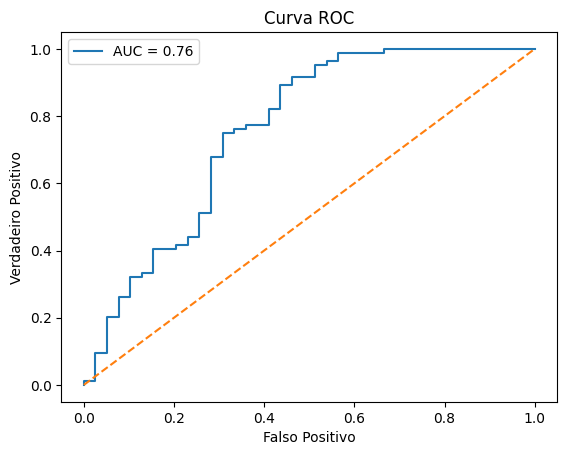

In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(y_test, classificador.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.legend()
plt.show()

Concluímos assim que o modelo performou significantemente melhor do que um classificador aleatório (0.26+), e a depender do cenário poderia ter alguma utilidade real.